In [17]:
import sys
sys.path.append('./utils')  # make sure Python knows where to look

# Display full output in Jupyter
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import time
import datetime
import sklearn
from imblearn import under_sampling, over_sampling, ensemble
import lightgbm as lgb
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

import transform_data_functions as utils_transform_data
import plot_data_functions as utils_plot_data
import ml_training_functions as utils_training
import import_shared_functions as utils_import
import file_handler_functions as utils_file
import performance_assessment_function as utils_assessment

In [18]:
# Load data from the 2018-07-25 to the 2018-08-14
DIR_INPUT='./data/simulated-data-transformed/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df = utils_file.read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: user 109 ms, sys: 130 ms, total: 239 ms
Wall time: 348 ms
622892 transactions loaded, containing 5515 fraudulent transactions


#### Define Starting and Ending date for training and testing data records

In [19]:
START_DATE = "2018-07-25"
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

# Number of folds for the prequential validation
n_folds = 4

start_date_training = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

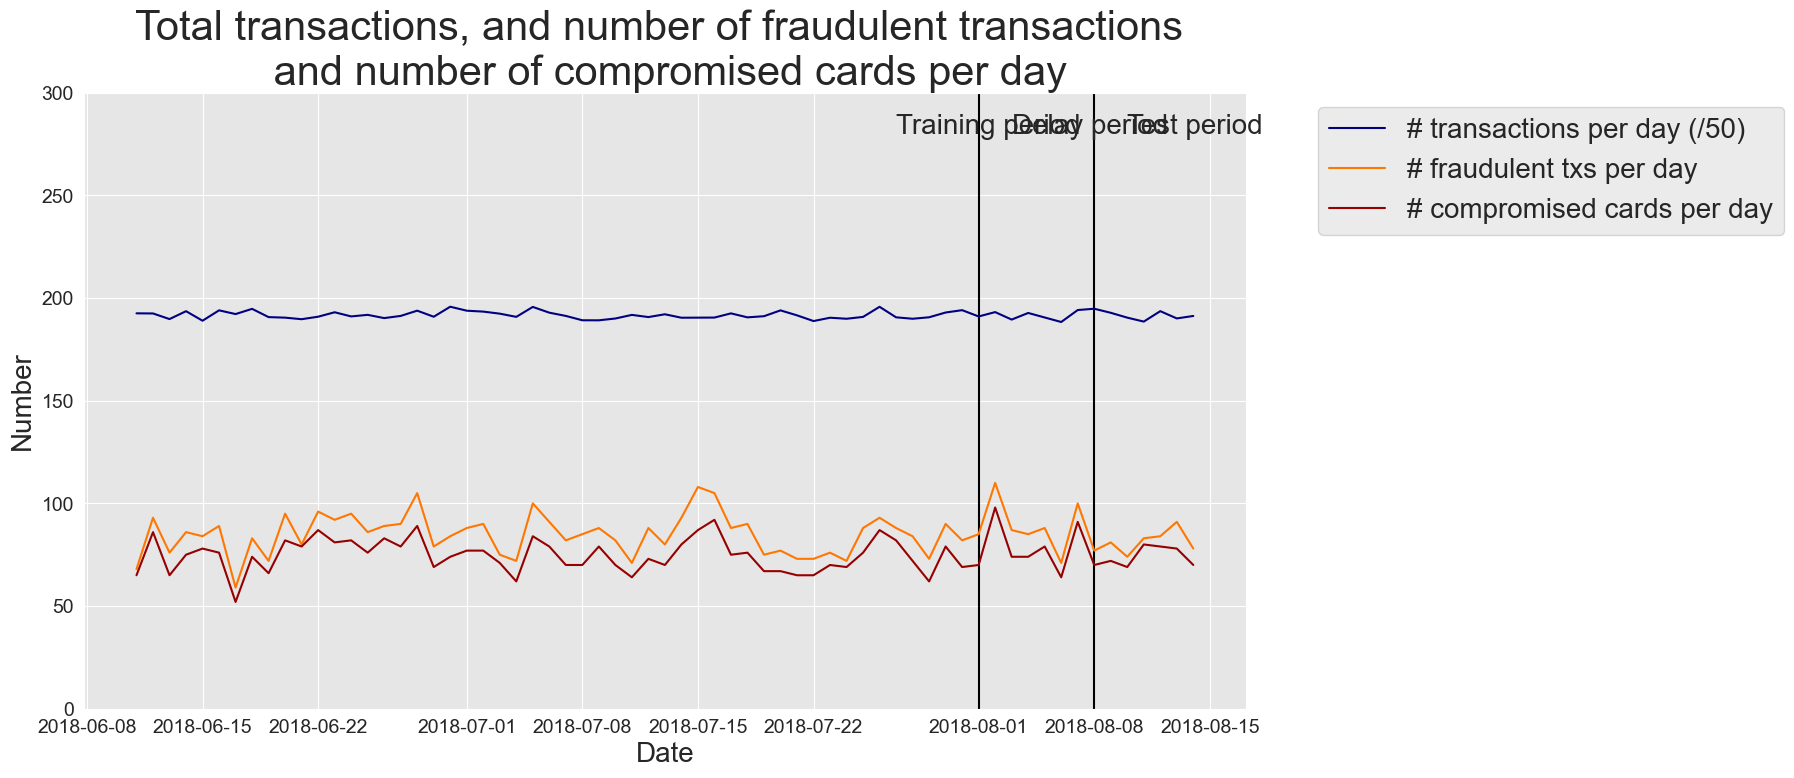

In [20]:
utils_plot_data.plot_nb_transaction_per_day(transactions_df, start_date_training, start_date_test, delta_train, delta_delay, delta_test)

In [21]:
# get_train_test_set() will be used in prequentialSplit() insgtead
train_df, test_df = utils_transform_data.get_train_test_set(transactions_df, start_date_training, delta_train, delta_delay ,delta_test)

In [22]:
# The trainig set contains 67240 transactions, among which 598 are fraudulent.
train_df.shape, train_df[train_df.TX_FRAUD==1].shape

((67240, 23), (598, 23))

In [23]:
#The test set contains 58264 transactions, among which 385 are fraudulent.
test_df.shape, test_df[test_df.TX_FRAUD==1].shape, f'Thus, the fraudulent transactions\'s proportion:  385/58264 = ~{(385/58264):.4f}'

((58264, 23),
 (385, 23),
 "Thus, the fraudulent transactions's proportion:  385/58264 = ~0.0066")

In [24]:
train_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
421597,1102483,2018-07-25 00:00:29,1111,2328,40.77,9936029,115,0,0,0,1,2.0,29.005000,24.0,29.191250,105.0,30.141810,1.0,0.0,10.0,0.0,32.0,0.0
421598,1102484,2018-07-25 00:01:08,676,6846,9.62,9936068,115,0,0,0,1,4.0,25.492500,15.0,19.151333,61.0,18.253607,2.0,0.0,5.0,0.0,27.0,0.0
421599,1102485,2018-07-25 00:01:35,402,4771,81.55,9936095,115,0,0,0,1,6.0,130.778333,11.0,183.875455,50.0,112.001800,0.0,0.0,12.0,0.0,37.0,0.0
421600,1102486,2018-07-25 00:01:43,4218,863,23.10,9936103,115,0,0,0,1,8.0,19.600000,24.0,21.201667,93.0,19.987849,2.0,0.0,6.0,0.0,22.0,0.0
421601,1102487,2018-07-25 00:02:26,3711,3599,59.25,9936146,115,0,0,0,1,5.0,84.656000,27.0,80.427407,110.0,74.158455,1.0,0.0,10.0,0.0,38.0,0.0


In [25]:
# Specified input features for model training and target features for predictions

output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

# card_precision_top_100 = sklearn.metrics.make_scorer(utils_import.card_precision_top_k_custom, 
#                                                      needs_proba=True, 
#                                                      top_k=100, 
#                                                      transactions_df=transactions_df_scorer)

def card_precision_scorer(estimator, X, y):
    # estimator must support predict_proba
    probs = estimator.predict_proba(X)[:, 1]
    # use the transactions metadata indexed by the current CV test fold rows
    preds_df = transactions_df_scorer.loc[X.index].copy()
    preds_df['predictions'] = probs
    # utils_training.card_precision_top_k returns (nb_list, list_per_day, mean)
    _, _, mean_cp = utils_training.card_precision_top_k(preds_df, 100)
    return mean_cp

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_scorer,
           }

In [26]:
model_performances = []
execution_times = []
 
prequential_split_indices=utils_training.prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)

In [27]:
len(prequential_split_indices), len(prequential_split_indices[0]), len(prequential_split_indices[0][0]) 

(4, 2, 67240)

### Test Performance on Logistic Regression Model

In [28]:
def save_and_display_performance_report(classifier_name, param_name, performance_df, execution_time, model_performances, execution_times):
    parameters_dict=dict(performance_df['Parameters'])
    performance_df['Parameters summary']=[parameters_dict[i][param_name] for i in range(len(parameters_dict))]
    model_performances.append([classifier_name, param_name, performance_df])
    execution_times.append(execution_time)
    utils_file.save_model_data('performances_ensembles.pkl', (model_performances, execution_times))
    return utils_assessment.get_summary_performances(performance_df, parameter_column_name="Parameters summary")

In [29]:
def filter_best_params(model_performance):
    best_param = {}
    for key, value in model_performance.items():
        if "clf__" in key:
            best_param[key] = value
    return best_param

In [30]:
# this handle imbalance dataset with 'class_weight' param
classifier = sklearn.linear_model.LogisticRegression() # -> based on param

# this handle imbalance dataset with hybrid-sampling technique
sampler_list = [('sampler1', over_sampling.SMOTE()),
                ('sampler2', under_sampling.RandomUnderSampler())]
parameters = {'clf__C':[0.1,1,10,100], 'clf__random_state':[0],
              'sampler1__sampling_strategy':[0.1], 
              'sampler2__sampling_strategy':[0.1, 0.5, 1], 
              'sampler1__random_state':[0], 'sampler2__random_state':[0]}

start_time = time.time()

logreg_performance_hybrid = utils_training.model_selection_wrapper_with_sample(
                                        transactions_df=transactions_df,
                                        classifier=classifier,
                                        sampler_list=sampler_list,
                                        input_features=input_features,
                                        output_feature=output_feature,
                                        parameters=parameters,
                                        scoring=scoring,
                                        cv=prequential_split_indices,
                                        start_date_training_for_valid=start_date_training_for_valid,
                                        start_date_training_for_test=start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_logreg_hybrid = time.time()-start_time

In [31]:
logreg_performance_hybrid.head(), execution_time_weighted_logreg_hybrid

(   AUC ROC Test  AUC ROC Test Std  Average precision Test  \
 0      0.869043          0.010433                0.567374   
 1      0.867647          0.012012                0.505570   
 2      0.866335          0.013375                0.461570   
 3      0.869680          0.010257                0.567636   
 4      0.869676          0.011315                0.525340   
 
    Average precision Test Std  Card Precision@100 Test  \
 0                    0.026079                 0.281429   
 1                    0.044574                 0.282500   
 2                    0.033232                 0.280357   
 3                    0.026953                 0.281071   
 4                    0.053866                 0.281429   
 
    Card Precision@100 Test Std  \
 0                     0.022177   
 1                     0.021005   
 2                     0.019545   
 3                     0.022574   
 4                     0.022565   
 
                                                          

In [32]:
save_and_display_performance_report(
    classifier.__class__.__name__ + '_hybrid', 
    'sampler2__sampling_strategy', 
    logreg_performance_hybrid, 
    execution_time_weighted_logreg_hybrid,
    model_performances,
    execution_times)

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.5,0.1,0.5
Validation performance,0.87+/-0.01,0.568+/-0.03,0.283+/-0.02
Test performance,0.87+/-0.01,0.568+/-0.03,0.283+/-0.02
Optimal parameter(s),0.5,0.1,0.5
Optimal test performance,0.87+/-0.01,0.568+/-0.03,0.283+/-0.02
Best hyperparameters,"{'clf__C': 100, 'clf__random_state': 0, 'sampler1__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler2__random_state': 0, 'sampler2__sampling_strategy': 0.5}","{'clf__C': 100, 'clf__random_state': 0, 'sampler1__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler2__random_state': 0, 'sampler2__sampling_strategy': 0.1}","{'clf__C': 0.1, 'clf__random_state': 0, 'sampler1__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler2__random_state': 0, 'sampler2__sampling_strategy': 0.5}"
Optimal hyperparameters,"{'clf__C': 100, 'clf__random_state': 0, 'sampler1__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler2__random_state': 0, 'sampler2__sampling_strategy': 0.5}","{'clf__C': 100, 'clf__random_state': 0, 'sampler1__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler2__random_state': 0, 'sampler2__sampling_strategy': 0.1}","{'clf__C': 0.1, 'clf__random_state': 0, 'sampler1__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler2__random_state': 0, 'sampler2__sampling_strategy': 0.5}"


In [33]:
best_params = filter_best_params(logreg_performance_hybrid)

In [34]:
# this handle imbalance dataset with only oversampling technique
sampler_list = [('sampler', over_sampling.SMOTE())]
parameters = {'sampler__sampling_strategy':[0.1], 'sampler__random_state':[0]} | best_params

start_time = time.time()

logreg_performance_over = utils_training.model_selection_wrapper_with_sample(
                                        transactions_df=transactions_df, 
                                        classifier=classifier, 
                                        sampler_list=sampler_list,
                                        input_features=input_features, 
                                        output_feature=output_feature,
                                        parameters=parameters, 
                                        scoring=scoring, 
                                        cv=prequential_split_indices,
                                        start_date_training_for_valid=start_date_training_for_valid,
                                        start_date_training_for_test=start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_logreg_over = time.time()-start_time

In [35]:
logreg_performance_over, execution_time_weighted_logreg_over

(   AUC ROC Test  AUC ROC Test Std  Average precision Test  \
 0      0.869682          0.010256                0.567641   
 
    Average precision Test Std  Card Precision@100 Test  \
 0                    0.026949                 0.281071   
 
    Card Precision@100 Test Std  \
 0                     0.022574   
 
                                                         Parameters  \
 0  {'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}   
 
    Execution time  AUC ROC Validation  AUC ROC Validation Std  \
 0        0.294538            0.869682                0.010256   
 
    Average precision Validation  Average precision Validation Std  \
 0                      0.567641                          0.026949   
 
    Card Precision@100 Validation  Card Precision@100 Validation Std  
 0                       0.281071                           0.022574  ,
 1.6225721836090088)

In [36]:
save_and_display_performance_report(
    classifier.__class__.__name__ + '_over', 
    'sampler__sampling_strategy', 
    logreg_performance_over, 
    execution_time_weighted_logreg_over,
    model_performances,
    execution_times)

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.1,0.1,0.1
Validation performance,0.87+/-0.01,0.568+/-0.03,0.281+/-0.02
Test performance,0.87+/-0.01,0.568+/-0.03,0.281+/-0.02
Optimal parameter(s),0.1,0.1,0.1
Optimal test performance,0.87+/-0.01,0.568+/-0.03,0.281+/-0.02
Best hyperparameters,"{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}","{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}","{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}"
Optimal hyperparameters,"{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}","{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}","{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}"


In [37]:
parameters = {'clf__class_weight':['balanced']} | best_params

start_time = time.time()

logreg_performance = utils_training.model_selection_wrapper(
                                        transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, prequential_split_indices,
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_logreg = time.time()-start_time


In [38]:
logreg_performance, execution_time_weighted_logreg

(   AUC ROC Test  AUC ROC Test Std  Average precision Test  \
 0       0.87049           0.01034                 0.54182   
 
    Average precision Test Std  Card Precision@100 Test  \
 0                    0.050807                   0.2825   
 
    Card Precision@100 Test Std                         Parameters  \
 0                     0.018881  {'clf__class_weight': 'balanced'}   
 
    Execution time  AUC ROC Validation  AUC ROC Validation Std  \
 0        0.256953             0.87049                 0.01034   
 
    Average precision Validation  Average precision Validation Std  \
 0                       0.54182                          0.050807   
 
    Card Precision@100 Validation  Card Precision@100 Validation Std  
 0                         0.2825                           0.018881  ,
 1.980112075805664)

In [39]:
save_and_display_performance_report(
    classifier.__class__.__name__, 
    'clf__class_weight', 
    logreg_performance, 
    execution_time_weighted_logreg,
    model_performances,
    execution_times)

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,balanced,balanced,balanced
Validation performance,0.87+/-0.01,0.542+/-0.05,0.283+/-0.02
Test performance,0.87+/-0.01,0.542+/-0.05,0.283+/-0.02
Optimal parameter(s),balanced,balanced,balanced
Optimal test performance,0.87+/-0.01,0.542+/-0.05,0.283+/-0.02
Best hyperparameters,{'clf__class_weight': 'balanced'},{'clf__class_weight': 'balanced'},{'clf__class_weight': 'balanced'}
Optimal hyperparameters,{'clf__class_weight': 'balanced'},{'clf__class_weight': 'balanced'},{'clf__class_weight': 'balanced'}


### Test Performance on Decision Tree Model

In [40]:
classifier = ensemble.BalancedBaggingClassifier()
parameters = {'clf__estimator':[sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0)], 
              'clf__n_estimators':[100],
              'clf__sampling_strategy':[0.02, 0.05, 0.1, 0.5, 1], 
              'clf__bootstrap':[True],
              'clf__sampler':[under_sampling.RandomUnderSampler()],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}
ensemble.BalancedBaggingClassifier(estimator=sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0),
                                   n_estimators=[100],
                                   )
start_time = time.time()

dt_performance = utils_training.model_selection_wrapper(
                                        transactions_df, classifier,
                                        input_features, output_feature,
                                        parameters, scoring, prequential_split_indices,
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_dt = time.time()-start_time


In [41]:
dt_performance, execution_time_weighted_dt

(   AUC ROC Test  AUC ROC Test Std  Average precision Test  \
 0      0.874286          0.010497                0.691888   
 1      0.876760          0.010564                0.692490   
 2      0.880429          0.007335                0.691282   
 3      0.879010          0.003941                0.658988   
 4      0.877285          0.004737                0.629229   
 
    Average precision Test Std  Card Precision@100 Test  \
 0                    0.017147                 0.288929   
 1                    0.013950                 0.288571   
 2                    0.016797                 0.292857   
 3                    0.016481                 0.291786   
 4                    0.013268                 0.292500   
 
    Card Precision@100 Test Std  \
 0                     0.016269   
 1                     0.015714   
 2                     0.019113   
 3                     0.021815   
 4                     0.021029   
 
                                                          

In [42]:
save_and_display_performance_report(
    classifier.__class__.__name__, 
    'clf__sampling_strategy', 
    dt_performance, 
    execution_time_weighted_dt,
    model_performances,
    execution_times)

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.1,0.05,0.1
Validation performance,0.88+/-0.01,0.692+/-0.01,0.293+/-0.02
Test performance,0.88+/-0.01,0.692+/-0.01,0.293+/-0.02
Optimal parameter(s),0.1,0.05,0.1
Optimal test performance,0.88+/-0.01,0.692+/-0.01,0.293+/-0.02
Best hyperparameters,"{'clf__bootstrap': True, 'clf__estimator': DecisionTreeClassifier(max_depth=20, random_state=0), 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampler': RandomUnderSampler(), 'clf__sampling_strategy': 0.1}","{'clf__bootstrap': True, 'clf__estimator': DecisionTreeClassifier(max_depth=20, random_state=0), 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampler': RandomUnderSampler(), 'clf__sampling_strategy': 0.05}","{'clf__bootstrap': True, 'clf__estimator': DecisionTreeClassifier(max_depth=20, random_state=0), 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampler': RandomUnderSampler(), 'clf__sampling_strategy': 0.1}"
Optimal hyperparameters,"{'clf__bootstrap': True, 'clf__estimator': DecisionTreeClassifier(max_depth=20, random_state=0), 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampler': RandomUnderSampler(), 'clf__sampling_strategy': 0.1}","{'clf__bootstrap': True, 'clf__estimator': DecisionTreeClassifier(max_depth=20, random_state=0), 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampler': RandomUnderSampler(), 'clf__sampling_strategy': 0.05}","{'clf__bootstrap': True, 'clf__estimator': DecisionTreeClassifier(max_depth=20, random_state=0), 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampler': RandomUnderSampler(), 'clf__sampling_strategy': 0.1}"


### Test Performance on Random Forest Model

In [43]:
classifier = ensemble.BalancedRandomForestClassifier()
parameters = {'clf__max_depth':[5,10,20,50], 
              'clf__n_estimators':[25,50,100], 
              'clf__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 
              'clf__random_state':[0], 
              'clf__n_jobs':[-1]}

start_time = time.time()

brf_performance = utils_training.model_selection_wrapper(
                                        transactions_df, classifier,
                                        input_features, output_feature,
                                        parameters, scoring, prequential_split_indices,
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_brf = time.time()-start_time


In [44]:
brf_performance.head(), execution_time_weighted_brf

(   AUC ROC Test  AUC ROC Test Std  Average precision Test  \
 0      0.838723          0.009131                0.589268   
 1      0.837317          0.013511                0.566166   
 2      0.838990          0.012012                0.562659   
 3      0.850935          0.016943                0.509909   
 4      0.859655          0.012900                0.484120   
 
    Average precision Test Std  Card Precision@100 Test  \
 0                    0.014155                 0.275000   
 1                    0.021538                 0.277500   
 2                    0.024662                 0.278929   
 3                    0.015923                 0.274643   
 4                    0.016325                 0.270357   
 
    Card Precision@100 Test Std  \
 0                     0.018309   
 1                     0.017536   
 2                     0.017536   
 3                     0.017710   
 4                     0.011926   
 
                                                          

In [45]:
save_and_display_performance_report(
    classifier.__class__.__name__, 
    'clf__sampling_strategy', 
    brf_performance, 
    execution_time_weighted_brf,
    model_performances,
    execution_times)

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.05,0.01,0.1
Validation performance,0.884+/-0.01,0.682+/-0.02,0.291+/-0.02
Test performance,0.884+/-0.01,0.682+/-0.02,0.291+/-0.02
Optimal parameter(s),0.05,0.01,0.1
Optimal test performance,0.884+/-0.01,0.682+/-0.02,0.291+/-0.02
Best hyperparameters,"{'clf__max_depth': 20, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampling_strategy': 0.05}","{'clf__max_depth': 20, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampling_strategy': 0.01}","{'clf__max_depth': 50, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampling_strategy': 0.1}"
Optimal hyperparameters,"{'clf__max_depth': 20, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampling_strategy': 0.05}","{'clf__max_depth': 20, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampling_strategy': 0.01}","{'clf__max_depth': 50, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__sampling_strategy': 0.1}"


### Test Performance on Different Boosting Models

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(
    subsample=0.8,           # speed + regularization
    max_features='sqrt',     # speed + regularization
    random_state=0
)

# Leaner, high-signal grid
sampler_list = [
    ('sampler1', over_sampling.SMOTE()),
    ('sampler2', under_sampling.RandomUnderSampler())
]
parameters = {
    'clf__n_estimators': [100, 200],      # smaller range
    'clf__max_depth': [3, 5],             # common depths
    'clf__learning_rate': [0.05, 0.1],    # focus on useful LR
    'sampler1__sampling_strategy': [0.1],
    'sampler2__sampling_strategy': [0.5], # one mid-level ratio
    'sampler1__random_state': [0],
    'sampler2__random_state': [0],
}

# Fewer folds during exploration
n_folds = 3

start_time = time.time()

gb_performance_hybrid = utils_training.model_selection_wrapper_with_sample(
    transactions_df=transactions_df,
    classifier=classifier,
    sampler_list=sampler_list,
    input_features=input_features,
    output_feature=output_feature,
    parameters=parameters,
    scoring=scoring,
    cv=prequential_split_indices,
    start_date_training_for_valid=start_date_training_for_valid,
    start_date_training_for_test=start_date_training_for_test,
    n_folds=n_folds,
    delta_train=delta_train,
    delta_delay=delta_delay,
    delta_assessment=delta_assessment,
    performance_metrics_list_grid=performance_metrics_list_grid,
    performance_metrics_list=performance_metrics_list,
    type_search='random',     # <- switch to randomized search
    n_iter=20,                # ~20 fits instead of hundreds
    n_jobs=-1
)

execution_time_weighted_gb_hybrid = time.time()-start_time

In [48]:
gb_performance_hybrid.head(), execution_time_weighted_gb_hybrid

(   AUC ROC Test  AUC ROC Test Std  Average precision Test  \
 0      0.856483          0.011508                0.523841   
 1      0.869133          0.007892                0.586415   
 2      0.868582          0.010273                0.579385   
 3      0.877237          0.008768                0.617087   
 4      0.871237          0.007576                0.587146   
 
    Average precision Test Std  Card Precision@100 Test  \
 0                    0.025072                 0.280357   
 1                    0.027047                 0.283929   
 2                    0.024270                 0.285000   
 3                    0.026486                 0.289643   
 4                    0.026951                 0.283929   
 
    Card Precision@100 Test Std  \
 0                     0.019096   
 1                     0.018416   
 2                     0.017453   
 3                     0.020438   
 4                     0.018881   
 
                                                          

In [49]:
save_and_display_performance_report(
    classifier.__class__.__name__ + '_hybrid', 
    'sampler2__sampling_strategy', 
    gb_performance_hybrid, 
    execution_time_weighted_gb_hybrid,
    model_performances,
    execution_times)

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.5,0.5,0.5
Validation performance,0.877+/-0.01,0.62+/-0.02,0.291+/-0.02
Test performance,0.877+/-0.01,0.62+/-0.02,0.291+/-0.02
Optimal parameter(s),0.5,0.5,0.5
Optimal test performance,0.877+/-0.01,0.62+/-0.02,0.291+/-0.02
Best hyperparameters,"{'sampler2__sampling_strategy': 0.5, 'sampler2__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler1__random_state': 0, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.05}","{'sampler2__sampling_strategy': 0.5, 'sampler2__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler1__random_state': 0, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.1}","{'sampler2__sampling_strategy': 0.5, 'sampler2__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler1__random_state': 0, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.1}"
Optimal hyperparameters,"{'sampler2__sampling_strategy': 0.5, 'sampler2__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler1__random_state': 0, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.05}","{'sampler2__sampling_strategy': 0.5, 'sampler2__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler1__random_state': 0, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.1}","{'sampler2__sampling_strategy': 0.5, 'sampler2__random_state': 0, 'sampler1__sampling_strategy': 0.1, 'sampler1__random_state': 0, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.1}"


In [50]:
best_params = filter_best_params(gb_performance_hybrid)

In [51]:
# this handle imbalance dataset with only under-resampling technique
sampler_list = [('sampler', over_sampling.SMOTE())]
parameters = {'sampler__sampling_strategy':[0.1],'sampler__random_state':[0]} | best_params

start_time = time.time()

gb_performance_over = utils_training.model_selection_wrapper_with_sample(
                                        transactions_df, classifier, sampler_list,
                                        input_features, output_feature,
                                        parameters, scoring, prequential_split_indices,
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_gb_over = time.time()-start_time


In [52]:
gb_performance_over.head(), execution_time_weighted_gb_over

(   AUC ROC Test  AUC ROC Test Std  Average precision Test  \
 0      0.871741          0.005923                0.626999   
 
    Average precision Test Std  Card Precision@100 Test  \
 0                    0.022205                 0.287857   
 
    Card Precision@100 Test Std  \
 0                     0.019233   
 
                                                         Parameters  \
 0  {'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}   
 
    Execution time  AUC ROC Validation  AUC ROC Validation Std  \
 0        6.029637            0.871741                0.005923   
 
    Average precision Validation  Average precision Validation Std  \
 0                      0.626999                          0.022205   
 
    Card Precision@100 Validation  Card Precision@100 Validation Std  
 0                       0.287857                           0.019233  ,
 12.7452712059021)

In [53]:
save_and_display_performance_report(
    classifier.__class__.__name__ + '_over', 
    'sampler__sampling_strategy', 
    gb_performance_over, 
    execution_time_weighted_gb_over,
    model_performances,
    execution_times)

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.1,0.1,0.1
Validation performance,0.872+/-0.01,0.627+/-0.02,0.288+/-0.02
Test performance,0.872+/-0.01,0.627+/-0.02,0.288+/-0.02
Optimal parameter(s),0.1,0.1,0.1
Optimal test performance,0.872+/-0.01,0.627+/-0.02,0.288+/-0.02
Best hyperparameters,"{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}","{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}","{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}"
Optimal hyperparameters,"{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}","{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}","{'sampler__random_state': 0, 'sampler__sampling_strategy': 0.1}"


In [54]:
classifier = lgb.LGBMClassifier()
parameters = {'clf__max_depth':[3,6,9], 
              'clf__n_estimators':[50,100], 
              'clf__learning_rate':[0.1,0.3],
              'clf__scale_pos_weight':[1,5,10,50,100],
              'clf__random_state':[0], 
              'clf__n_jobs':[-1]}

start_time = time.time()

lgbm_performance = utils_training.model_selection_wrapper(
                                        transactions_df, classifier,
                                        input_features, output_feature,
                                        parameters, scoring, prequential_split_indices,
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_lgbm = time.time()-start_time


[LightGBM] [Info] Number of positive: 598, number of negative: 66642
[LightGBM] [Info] Number of positive: 633, number of negative: 66295
[LightGBM] [Info] Number of positive: 536, number of negative: 66288
[LightGBM] [Info] Number of positive: 536, number of negative: 66288
[LightGBM] [Info] Number of positive: 598, number of negative: 66642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 67240, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008894 -> initscore=-4.713500
[LightGBM] [Info] Start training from score -4.713500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

In [55]:
lgbm_performance.head(), execution_time_weighted_lgbm

(   AUC ROC Test  AUC ROC Test Std  Average precision Test  \
 0      0.879383          0.003104                0.648802   
 1      0.877292          0.006924                0.620050   
 2      0.870154          0.009488                0.589208   
 3      0.869212          0.011669                0.575109   
 4      0.869364          0.015196                0.549640   
 
    Average precision Test Std  Card Precision@100 Test  \
 0                    0.015581                 0.289643   
 1                    0.009172                 0.289643   
 2                    0.054589                 0.287857   
 3                    0.029528                 0.285714   
 4                    0.020238                 0.282500   
 
    Card Precision@100 Test Std  \
 0                     0.020785   
 1                     0.018691   
 2                     0.020064   
 3                     0.015485   
 4                     0.016641   
 
                                                          

In [56]:
save_and_display_performance_report(
    classifier.__class__.__name__, 
    'clf__scale_pos_weight', 
    lgbm_performance, 
    execution_time_weighted_lgbm,
    model_performances,
    execution_times)

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,1,1,1
Validation performance,0.886+/-0.0,0.653+/-0.01,0.29+/-0.02
Test performance,0.886+/-0.0,0.653+/-0.01,0.29+/-0.02
Optimal parameter(s),1,1,1
Optimal test performance,0.886+/-0.0,0.653+/-0.01,0.29+/-0.02
Best hyperparameters,"{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 1}","{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 1}","{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 50, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 1}"
Optimal hyperparameters,"{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 1}","{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 1}","{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 50, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 1}"


In [57]:
classifier = XGBClassifier()
parameters = {'clf__max_depth':[3,6,9], 
              'clf__n_estimators':[25,50,100], 
              'clf__learning_rate':[0.1,0.3], 
              'clf__scale_pos_weight':[1,5,10,50,100], 
              'clf__random_state':[0], 
              'clf__n_jobs':[-1]}

start_time = time.time()

xgb_performance = utils_training.model_selection_wrapper(
                                        transactions_df, classifier,
                                        input_features, output_feature,
                                        parameters, scoring, prequential_split_indices,
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_xgb = time.time()-start_time


In [58]:
xgb_performance.head(), execution_time_weighted_xgb

(   AUC ROC Test  AUC ROC Test Std  Average precision Test  \
 0      0.863545          0.005084                0.615565   
 1      0.857461          0.006808                0.591297   
 2      0.860501          0.004875                0.594381   
 3      0.864794          0.006194                0.558351   
 4      0.861550          0.006598                0.535177   
 
    Average precision Test Std  Card Precision@100 Test  \
 0                    0.023370                 0.288214   
 1                    0.017641                 0.282500   
 2                    0.018486                 0.283571   
 3                    0.015520                 0.282857   
 4                    0.020648                 0.279286   
 
    Card Precision@100 Test Std  \
 0                     0.017302   
 1                     0.018527   
 2                     0.017098   
 3                     0.018599   
 4                     0.015828   
 
                                                          

In [59]:
save_and_display_performance_report(
    classifier.__class__.__name__, 
    'clf__scale_pos_weight', 
    xgb_performance, 
    execution_time_weighted_xgb,
    model_performances,
    execution_times)

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,5,1,10
Validation performance,0.887+/-0.01,0.653+/-0.02,0.292+/-0.02
Test performance,0.887+/-0.01,0.653+/-0.02,0.292+/-0.02
Optimal parameter(s),5,1,10
Optimal test performance,0.887+/-0.01,0.653+/-0.02,0.292+/-0.02
Best hyperparameters,"{'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 50, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 5}","{'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 1}","{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 50, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 10}"
Optimal hyperparameters,"{'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 50, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 5}","{'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 1}","{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 50, 'clf__n_jobs': -1, 'clf__random_state': 0, 'clf__scale_pos_weight': 10}"


In [62]:
classifier = CatBoostClassifier()
parameters = {
    'clf__iterations': [100],
    'clf__learning_rate': [0.01, 0.05],
    'clf__depth': [6, 8],
    'clf__scale_pos_weight':[5,10,50], 
    'clf__random_state':[0]
}

start_time = time.time()

cat_performance = utils_training.model_selection_wrapper(
                                        transactions_df, classifier,
                                        input_features, output_feature,
                                        parameters, scoring, prequential_split_indices,
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_cat = time.time()-start_time


0:	learn: 0.6839698	total: 91.3ms	remaining: 9.04s
1:	learn: 0.6750737	total: 107ms	remaining: 5.26s
0:	learn: 0.6844624	total: 109ms	remaining: 10.8s
2:	learn: 0.6662634	total: 131ms	remaining: 4.24s
1:	learn: 0.6761233	total: 147ms	remaining: 7.2s
3:	learn: 0.6576382	total: 147ms	remaining: 3.52s
0:	learn: 0.6839929	total: 142ms	remaining: 14.1s
2:	learn: 0.6678419	total: 174ms	remaining: 5.62s
0:	learn: 0.6845699	total: 169ms	remaining: 16.7s
1:	learn: 0.6750976	total: 168ms	remaining: 8.25s
4:	learn: 0.6491395	total: 186ms	remaining: 3.53s
3:	learn: 0.6597669	total: 192ms	remaining: 4.61s
1:	learn: 0.6762630	total: 183ms	remaining: 8.95s
2:	learn: 0.6663278	total: 183ms	remaining: 5.9s
5:	learn: 0.6408839	total: 206ms	remaining: 3.23s
0:	learn: 0.6843744	total: 70.2ms	remaining: 6.95s
4:	learn: 0.6517295	total: 218ms	remaining: 4.14s
3:	learn: 0.6577066	total: 207ms	remaining: 4.97s
6:	learn: 0.6327435	total: 226ms	remaining: 3s
2:	learn: 0.6679775	total: 218ms	remaining: 7.05s
0:	

In [63]:
cat_performance.head(), execution_time_weighted_cat

(   AUC ROC Test  AUC ROC Test Std  Average precision Test  \
 0      0.871828          0.006333                0.591181   
 1      0.868613          0.007646                0.587883   
 2      0.871156          0.009215                0.533255   
 3      0.871433          0.006045                0.629967   
 4      0.871976          0.006921                0.629132   
 
    Average precision Test Std  Card Precision@100 Test  \
 0                    0.017486                 0.280714   
 1                    0.015899                 0.281786   
 2                    0.021332                 0.276786   
 3                    0.016557                 0.293571   
 4                    0.015992                 0.294286   
 
    Card Precision@100 Test Std  \
 0                     0.017038   
 1                     0.018361   
 2                     0.015498   
 3                     0.019808   
 4                     0.020578   
 
                                                          

In [64]:
save_and_display_performance_report(
    classifier.__class__.__name__, 
    'clf__scale_pos_weight', 
    cat_performance, 
    execution_time_weighted_cat,
    model_performances,
    execution_times)

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,50,5,10
Validation performance,0.878+/-0.01,0.642+/-0.01,0.294+/-0.02
Test performance,0.878+/-0.01,0.642+/-0.01,0.294+/-0.02
Optimal parameter(s),50,5,10
Optimal test performance,0.878+/-0.01,0.642+/-0.01,0.294+/-0.02
Best hyperparameters,"{'clf__depth': 8, 'clf__iterations': 100, 'clf__learning_rate': 0.05, 'clf__random_state': 0, 'clf__scale_pos_weight': 50}","{'clf__depth': 8, 'clf__iterations': 100, 'clf__learning_rate': 0.05, 'clf__random_state': 0, 'clf__scale_pos_weight': 5}","{'clf__depth': 6, 'clf__iterations': 100, 'clf__learning_rate': 0.05, 'clf__random_state': 0, 'clf__scale_pos_weight': 10}"
Optimal hyperparameters,"{'clf__depth': 8, 'clf__iterations': 100, 'clf__learning_rate': 0.05, 'clf__random_state': 0, 'clf__scale_pos_weight': 50}","{'clf__depth': 8, 'clf__iterations': 100, 'clf__learning_rate': 0.05, 'clf__random_state': 0, 'clf__scale_pos_weight': 5}","{'clf__depth': 6, 'clf__iterations': 100, 'clf__learning_rate': 0.05, 'clf__random_state': 0, 'clf__scale_pos_weight': 10}"


## Load Save Model Performance Summary

In [65]:
model_performances, execution_times = utils_file.load_model_data('performances_ensembles.pkl')

Object successfully loaded from pickle file:


In [66]:
model_performances_list = []

for model_performance in model_performances:
    # # Select parameter of interest (sampling_strategy)
    # parameters_dict=dict(p['Parameters'])
    # logreg_performance_hybrid['Parameters summary']=[parameters_dict[i][p[1]] for i in range(len(parameters_dict))]
    temp_model_name = model_performance[0]
    temp_performance_summary = utils_assessment.get_summary_performances(model_performance[2], parameter_column_name="Parameters summary")
    model_performances_list.append((temp_model_name, temp_performance_summary))
    print("\n***** " + temp_model_name + " ***** ")
    print(model_performance[1] + ":")
    print(temp_performance_summary)


***** LogisticRegression_hybrid ***** 
sampler2__sampling_strategy:
                                                                                                                                                                                             AUC ROC  \
Best estimated parameters                                                                                                                                                                        0.5   
Validation performance                                                                                                                                                                   0.87+/-0.01   
Test performance                                                                                                                                                                         0.87+/-0.01   
Optimal parameter(s)                                                                                                               

## Ranking model based on different Performance Metrics

In [67]:
target_metric = 'AUC ROC'
utils_assessment.rank_models(model_performances_list, metrics=target_metric, weights={target_metric:1})

,Model,AUC ROC,Score
0,XGBClassifier,0.887,0.887
1,LGBMClassifier,0.886,0.886
2,BalancedRandomForestClassifier,0.884,0.884
3,BalancedBaggingClassifier,0.880,0.880
4,CatBoostClassifier,0.878,0.878
5,GradientBoostingClassifier_hybrid,0.877,0.877
6,GradientBoostingClassifier_over,0.872,0.872
7,LogisticRegression_hybrid,0.870,0.870
8,LogisticRegression_over,0.870,0.870
9,LogisticRegression,0.870,0.870


In [68]:
target_metric = 'Average precision'
utils_assessment.rank_models(model_performances_list, metrics=target_metric, weights={target_metric:1})

,Model,Average precision,Score
0,BalancedBaggingClassifier,0.692,0.692
1,BalancedRandomForestClassifier,0.682,0.682
2,LGBMClassifier,0.653,0.653
3,XGBClassifier,0.653,0.653
4,CatBoostClassifier,0.642,0.642
5,GradientBoostingClassifier_over,0.627,0.627
6,GradientBoostingClassifier_hybrid,0.620,0.620
7,LogisticRegression_hybrid,0.568,0.568
8,LogisticRegression_over,0.568,0.568
9,LogisticRegression,0.542,0.542


In [69]:
target_metric = 'Card Precision@100'
utils_assessment.rank_models(model_performances_list, metrics=target_metric, weights={target_metric:1})

,Model,Card Precision@100,Score
0,CatBoostClassifier,0.294,0.294
1,BalancedBaggingClassifier,0.293,0.293
2,XGBClassifier,0.292,0.292
3,BalancedRandomForestClassifier,0.291,0.291
4,GradientBoostingClassifier_hybrid,0.291,0.291
5,LGBMClassifier,0.290,0.290
6,GradientBoostingClassifier_over,0.288,0.288
7,LogisticRegression_hybrid,0.283,0.283
8,LogisticRegression,0.283,0.283
9,LogisticRegression_over,0.281,0.281


In [70]:
target_metrics = ['AUC ROC', 'Average precision', 'Card Precision@100']
weights = {target_metrics[0]: 0.2, target_metrics[1]: 0.4, target_metrics[2]: 0.4}
model_rank = utils_assessment.rank_models(model_performances_list, metrics=target_metrics, weights=weights)
model_rank

,Model,AUC ROC,Average precision,Card Precision@100,Weighted Score
0,BalancedBaggingClassifier,0.880,0.692,0.293,0.5700
1,BalancedRandomForestClassifier,0.884,0.682,0.291,0.5660
2,XGBClassifier,0.887,0.653,0.292,0.5554
3,LGBMClassifier,0.886,0.653,0.290,0.5544
4,CatBoostClassifier,0.878,0.642,0.294,0.5500
5,GradientBoostingClassifier_over,0.872,0.627,0.288,0.5404
6,GradientBoostingClassifier_hybrid,0.877,0.620,0.291,0.5398
7,LogisticRegression_hybrid,0.870,0.568,0.283,0.5144
8,LogisticRegression_over,0.870,0.568,0.281,0.5136
9,LogisticRegression,0.870,0.542,0.283,0.5040


In [71]:
models_metric_best_params = {}
target_metrics = ['AUC ROC', 'Average precision', 'Card Precision@100']

for metric in target_metrics:
    metric_best_params = {}
    for i in range(len(model_rank)):
        model_raw = model_rank.iloc[i]['Model']
        model_split = model_raw.split("_")
        if model_split[0] not in metric_best_params:
            for model_performance in model_performances_list:
                if model_performance[0] == model_raw:
                    best_params = model_performance[1].loc['Best hyperparameters'].loc[metric]
                    best_params = filter_best_params(best_params)
                    metric_best_params[model_split[0]] = {key.replace("clf__", ""): value for key, value in (best_params).items()}
                    break
    models_metric_best_params[metric] = metric_best_params
    
models_metric_best_params

{'AUC ROC': {'BalancedBaggingClassifier': {'bootstrap': True,
   'estimator': DecisionTreeClassifier(max_depth=20, random_state=0),
   'n_estimators': 100,
   'n_jobs': -1,
   'random_state': 0,
   'sampler': RandomUnderSampler(),
   'sampling_strategy': 0.1},
  'BalancedRandomForestClassifier': {'max_depth': 20,
   'n_estimators': 100,
   'n_jobs': -1,
   'random_state': 0,
   'sampling_strategy': 0.05},
  'XGBClassifier': {'learning_rate': 0.3,
   'max_depth': 3,
   'n_estimators': 50,
   'n_jobs': -1,
   'random_state': 0,
   'scale_pos_weight': 5},
  'LGBMClassifier': {'learning_rate': 0.1,
   'max_depth': 3,
   'n_estimators': 100,
   'n_jobs': -1,
   'random_state': 0,
   'scale_pos_weight': 1},
  'CatBoostClassifier': {'depth': 8,
   'iterations': 100,
   'learning_rate': 0.05,
   'random_state': 0,
   'scale_pos_weight': 50},
  'GradientBoostingClassifier': {},
  'LogisticRegression': {'C': 100, 'random_state': 0}},
 'Average precision': {'BalancedBaggingClassifier': {'bootstra

In [72]:
# Convert to a list of dictionaries for easier normalization
list_data = []
for outer_key, inner_dict in models_metric_best_params.items():
    for inner_key, value_dict in inner_dict.items():
        row = {'outer_key': outer_key, 'inner_key': inner_key}
        row.update(value_dict)
        list_data.append(row)

# Create the initial DataFrame
df_reshaped = pd.DataFrame(list_data)
df_reshaped

# Sort the DataFrame first by 'inner_key' and then optionally by 'outer_key'
df_sorted = df_reshaped.sort_values(by=['inner_key', 'outer_key'], ascending=[True, True])

# # Reset index for cleaner display (optional)
# df_sorted = df_sorted.reset_index(drop=True)

df_sorted

,outer_key,inner_key,bootstrap,estimator,n_estimators,n_jobs,random_state,sampler,sampling_strategy,max_depth,learning_rate,scale_pos_weight,depth,iterations,C
0,AUC ROC,BalancedBaggingClassifier,True,"DecisionTreeClassifier(max_depth=20, random_state=0)",100.0,-1.0,0.0,RandomUnderSampler(),0.10,NaN,NaN,NaN,NaN,NaN,NaN
7,Average precision,BalancedBaggingClassifier,True,"DecisionTreeClassifier(max_depth=20, random_state=0)",100.0,-1.0,0.0,RandomUnderSampler(),0.05,NaN,NaN,NaN,NaN,NaN,NaN
14,Card Precision@100,BalancedBaggingClassifier,True,"DecisionTreeClassifier(max_depth=20, random_state=0)",100.0,-1.0,0.0,RandomUnderSampler(),0.10,NaN,NaN,NaN,NaN,NaN,NaN
1,AUC ROC,BalancedRandomForestClassifier,NaN,NaN,100.0,-1.0,0.0,NaN,0.05,20.0,NaN,NaN,NaN,NaN,NaN
8,Average precision,BalancedRandomForestClassifier,NaN,NaN,100.0,-1.0,0.0,NaN,0.01,20.0,NaN,NaN,NaN,NaN,NaN
15,Card Precision@100,BalancedRandomForestClassifier,NaN,NaN,100.0,-1.0,0.0,NaN,0.10,50.0,NaN,NaN,NaN,NaN,NaN
4,AUC ROC,CatBoostClassifier,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.05,50.0,8.0,100.0,NaN
11,Average precision,CatBoostClassifier,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.05,5.0,8.0,100.0,NaN
18,Card Precision@100,CatBoostClassifier,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.05,10.0,6.0,100.0,NaN
5,AUC ROC,GradientBoostingClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
utils_file.save_model_data('best_params_ensembles.pkl', models_metric_best_params)